## Plant Disease Classification

# Load the dataset

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files  # upload the kaggle.json file for access to download the dataset
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d arjuntejaswi/plant-village  # dataset kaggle api 

100% 328M/329M [00:02<00:00, 144MB/s]
100% 329M/329M [00:02<00:00, 127MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip plant-village.zip -d train

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train/PlantVillage/PlantVillage_potato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds),len(val_ds),len(test_ds)

(94, 27, 14)

## Data Visualisation

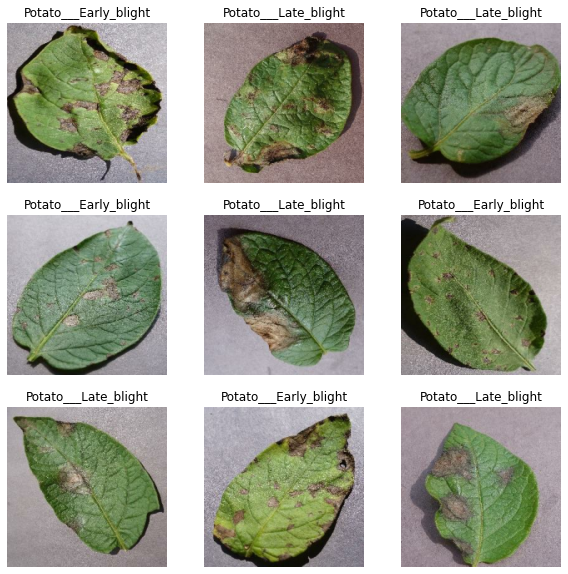

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

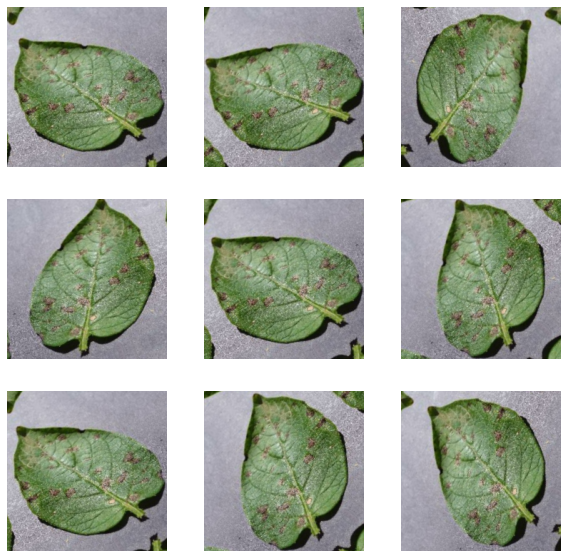

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

## Load Resnet50 model

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

## Create the base model from the pre-trained convnets

In [ ]:
# Create the base model from the pre-trained model Resnet50
IMG_SHAPE = (IMAGE_SIZE,IMAGE_SIZE) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
(IMAGE_SIZE,IMAGE_SIZE) + (3,)

(224, 224, 3)

This feature extractor converts each `224x224x3` image into a `7x7x2048` block of features.

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


## Feature extraction
In this step, we will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Add a classification head

To generate predictions from the block of features, average over the spatial `7x7` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 2048-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 3)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~94% accuracy on the validation set.


In [ ]:
initial_epochs = 10

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
94/94 [==============================] - 28s 214ms/step - loss: 0.7574 - accuracy: 0.6471 - val_loss: 0.5680 - val_accuracy: 0.7870
Epoch 2/10
94/94 [==============================] - 21s 192ms/step - loss: 0.4594 - accuracy: 0.8322 - val_loss: 0.3362 - val_accuracy: 0.9329
Epoch 3/10
94/94 [==============================] - 20s 191ms/step - loss: 0.3299 - accuracy: 0.8883 - val_loss: 0.2512 - val_accuracy: 0.9340
Epoch 4/10
94/94 [==============================] - 20s 191ms/step - loss: 0.2582 - accuracy: 0.9225 - val_loss: 0.2115 - val_accuracy: 0.9444
Epoch 5/10
94/94 [==============================] - 20s 191ms/step - loss: 0.2406 - accuracy: 0.9222 - val_loss: 0.1789 - val_accuracy: 0.9560
Epoch 6/10
94/94 [==============================] - 20s 191ms/step - loss: 0.1806 - accuracy: 0.9508 - val_loss: 0.1427 - val_accuracy: 0.9693
Epoch 7/10
94/94 [==============================] - 21s 198ms/step - loss: 0.1716 - accuracy: 0.9515 - val_loss: 0.1421 - val_accuracy: 0.9676

Test Accuracy - ~95%

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

14/14 [==============================] - 4s 123ms/step - loss: 0.0935 - accuracy: 0.9777
Test accuracy : 0.9776785969734192


### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],'-o', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], '-o', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Resnet50 \n Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], '-o', label='Training Loss')
plt.plot(history.history['val_loss'], '-o', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Resnet50 \n Training and Validation Loss')
plt.show()

## Fine tuning



### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


### Compile the model


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

32

### Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
94/94 [==============================] - 32s 243ms/step - loss: 0.0781 - accuracy: 0.9726 - val_loss: 0.0466 - val_accuracy: 0.9838
Epoch 11/20
94/94 [==============================] - 24s 228ms/step - loss: 0.0531 - accuracy: 0.9794 - val_loss: 0.0415 - val_accuracy: 0.9792
Epoch 12/20
94/94 [==============================] - 24s 228ms/step - loss: 0.0379 - accuracy: 0.9860 - val_loss: 0.0147 - val_accuracy: 0.9929
Epoch 13/20
94/94 [==============================] - 24s 227ms/step - loss: 0.0313 - accuracy: 0.9893 - val_loss: 0.0181 - val_accuracy: 0.9907
Epoch 14/20
94/94 [==============================] - 24s 227ms/step - loss: 0.0257 - accuracy: 0.9886 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 15/20
94/94 [==============================] - 24s 228ms/step - loss: 0.0174 - accuracy: 0.9953 - val_loss: 0.0295 - val_accuracy: 0.9931
Epoch 16/20
94/94 [==============================] - 24s 227ms/step - loss: 0.0155 - accuracy: 0.9940 - val_loss: 0.0170 - val_accuracy:

Overfittng ? ---- No, Model is Not Overfit because Overfit that means (Low Bias and High Variance) means tranning data accuracy is good but test data or validation data accuracy is low or bad...but here tranning data accuracy and validation data accuracy almost similar and good. 

After fine tuning the model reaches 100% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

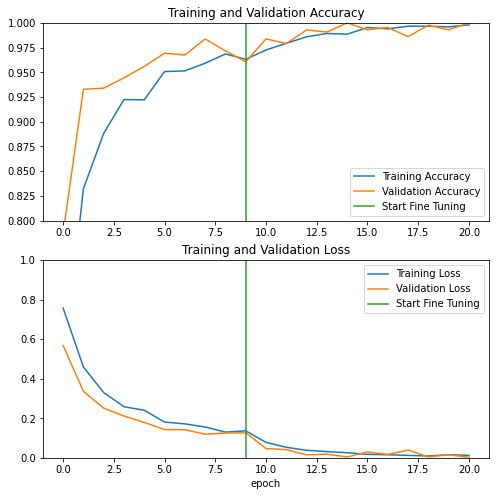

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/Colab Notebooks/Data/model_resnet50.h5')

### Evaluation and prediction

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Load the model and make prediction

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model1=load_model('/content/drive/MyDrive/Colab Notebooks/Data/resnet50_plant_disease.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


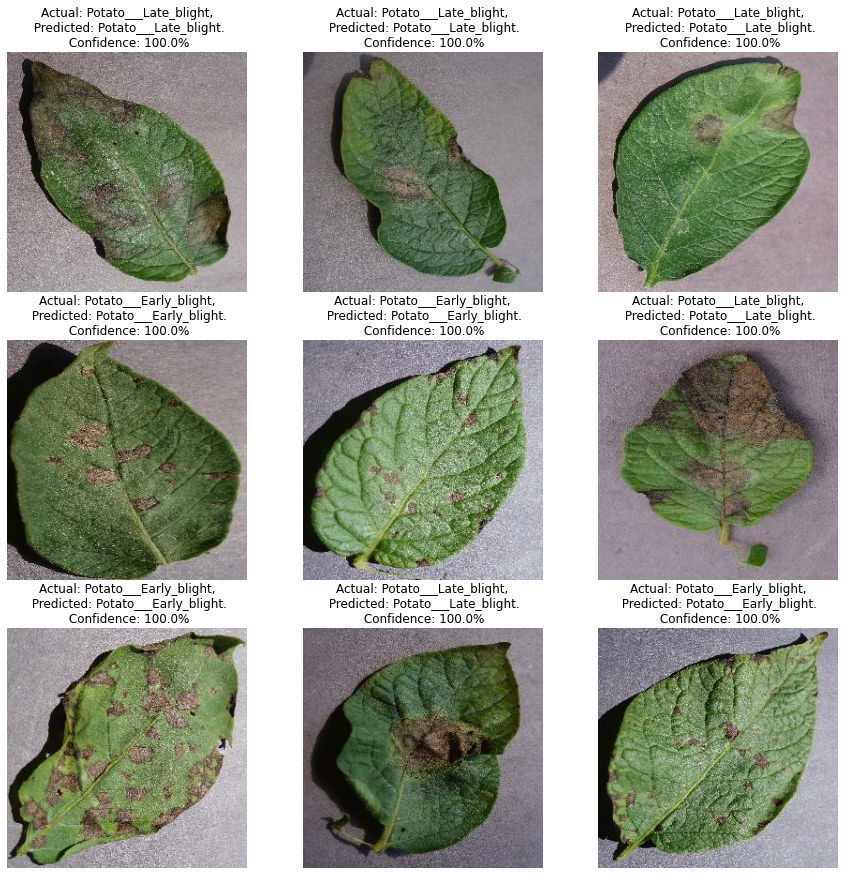

In [ ]:
actual1 = []
predicted1 = []

plt.figure(figsize=(15, 15))
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        predicted1.append(predicted_class)
        actual1.append(actual_class) 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

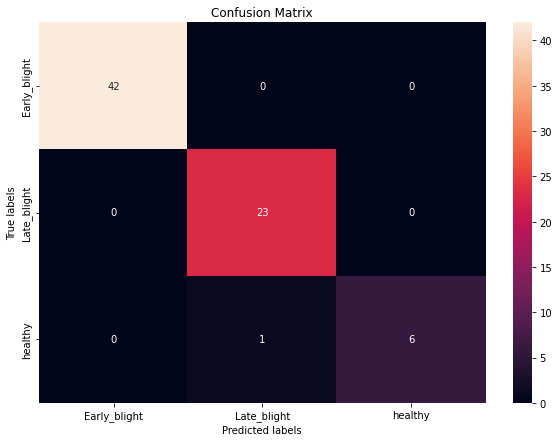

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Early_blight', 'Late_blight','healthy']); ax.yaxis.set_ticklabels(['Early_blight', 'Late_blight', 'healthy']);

In [ ]:
print(classification_report(actual1, predicted1))

                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00        42
 Potato___Late_blight       0.96      1.00      0.98        23
     Potato___healthy       1.00      0.86      0.92         7

             accuracy                           0.99        72
            macro avg       0.99      0.95      0.97        72
         weighted avg       0.99      0.99      0.99        72

